# Análisis expresión diferencial - datos sin replicas biológicas

Replico algunos pasos del taller, agregando apuntes y modificaciones que considere apropiadas de acuerdo a la documentación de edgeR.

In [1]:
# Required libraries validation
missing_packages <- character()
for (package in c(
  "edgeR"
)) {
  if (!require(package, quietly = TRUE, character.only = TRUE)) {
    missing_packages <- append(missing_packages, package)
  }
}

if (length(missing_packages) > 0) {
  stop(
    sprintf(
      "Missing the following packages: %s",
      paste(missing_packages, collapse = ", ")
    ),
    call. = FALSE
  )
}


## 1. Load Data

In [2]:
data <- read.table(
  file = "Private_Data/K562/K562.total.merged.txt", header = TRUE, row.names = 1
)
# 4 grupos SIN REPLICAS
group <- factor(c("Ce", "Cy", "Nl", "Nu"))
data <- DGEList(counts = data, group = group)
head(data)


An object of class "DGEList"
$counts
                                         K562Cell K562Cytosol K562Nucleolus
chr10_AsnGTT_22518418_22518448_5tRNAr         273         604            29
chr10_AsnGTT_22518438_22518511_total          278         802            70
chr10_AsnGTT_22518501_22518531_3tRNAr         270         157            40
chr10_PseudoCAA_34591396_34591426_5tRNAr        0           0             0
chr10_PseudoCAA_34591416_34591483_total         0           1             0
chr10_PseudoCAA_34591473_34591503_3tRNAr        0           1             0
                                         K562Nucleus
chr10_AsnGTT_22518418_22518448_5tRNAr             13
chr10_AsnGTT_22518438_22518511_total              67
chr10_AsnGTT_22518501_22518531_3tRNAr             46
chr10_PseudoCAA_34591396_34591426_5tRNAr           0
chr10_PseudoCAA_34591416_34591483_total            0
chr10_PseudoCAA_34591473_34591503_3tRNAr           0

$samples
              group lib.size norm.factors
K562Cell         Ce  2882866            1
K562Cytosol      Cy 15265956            1
K562Nucleolus    Nl   478030            1
K562Nucleus      Nu   393603            1

## 2. Filtering

Nótese el cambio en los tamaños de las bibliotecas:

In [3]:
# filtering keeps genes that have CPM >= CPM.cutoff in MinSampleSize samples,
#   where CPM.cutoff = min.count/median(lib.size)*1e6 and MinSampleSize is the
#   smallest group sample size or, more generally, the minimum inverse leverage
#   computed from the design matrix.

keep <- filterByExpr(data, group = group, min.count = 10)
data <- data[keep, , keep.lib.sizes = FALSE]
data$samples


,group,lib.size,norm.factors
,<fct>,<dbl>,<dbl>
K562Cell,Ce,2882162,1
K562Cytosol,Cy,15262880,1
K562Nucleolus,Nl,477845,1
K562Nucleus,Nu,393438,1


## 3. Normalization

edgeR realiza la normalización mediante factores de corrección en el modelo. NO TRANSFORMA los datos. NO se debe ingresar datos transformados tampoco (e.g. RPKM o FPKM)

- En general, solo se necesita normalizar __efectos específicos de muestra__. Por ejemplo, el tamaño del gen influencia el conteo de reads, pero al comparar entre muestras cada gen, estos al tener la misma longitud, en principio, tiene un efecto pequeño e históricamente no se suele tener en cuenta.
- La profundidad de secuenciación afecta el conteo de lecturas. edgeR ajusta este efecto automáticamente.
- Históricamente el contenido GC cambia poco entre muestras, pero algunos estudios han mostrado efectos __específicos de muestra__.
- Genes muy expresados pueden causar que otros sean sub-muestreados. 

In [4]:
# Calculate scaling factors to convert the raw library sizes for a
#   set of sequenced samples into normalized effective library sizes.

# normLibSizes is the new name for calcNormFactors. The two functions
#   are equivalent but calcNormFactors will eventually be retired.
data_normalized <- normLibSizes(data)


> "The effective library sizes for use in downstream analysis
are lib.size \* norm.factors where lib.size contains the original library sizes and norm.factors
is the vector of scaling factors computed by this function."

Nótese como ha cambiado el data frame samples. lib.size se mantiene, lo que cambia es norm.factors:

In [5]:
cat("Samples data after normalization:")
data_normalized$samples


Samples data after normalization:

,group,lib.size,norm.factors
,<fct>,<dbl>,<dbl>
K562Cell,Ce,2882162,0.3924466
K562Cytosol,Cy,15262880,0.8628079
K562Nucleolus,Nl,477845,1.6481022
K562Nucleus,Nu,393438,1.7919306


## 4. Dispersion estimation and model fit

Normalmente, para estimar la dispersión común y por el tag:

```R
data <-estimateDisp(data)
```

En __ESTE__, los datos del ejercicio NO poseen replicas biológicas. Entre las alternativas que la documentación de edgeR sugiere esta tomar un valor de dispersión con base a la experiencia en datos similares. Recordar que la dispersión es el cuadrado del coeficiente de variación biológico (BCV).

__NOTA 1__: esta forma de estimar dispersión y el test exacto son adecuados solo cuando se tiene UN SOLO factor. Modelos mas complejos requieren otras formas de abordarlo. 

In [6]:
design <- model.matrix(~group)
common_bcv <- 0.2


En el taller se usa:

```R
d <- estimateGLMCommonDisp(d, design, method="deviance", robust="TRUE", subset=NULL)
```

Pero de acuerdo a la documentación esto se recomienda aplicarlo en __CONJUNTO__ con una "_design matrix_" reducida, lo que equivale a remover factores explicativos con el fin de generar grados de libertad residuales. Eso NO se hizo (ademas de que solo se tiene un factor de 4 niveles). Ademas, intentarlo aplicar lanza un Warning y deja d$common.dispersion con valor NA. Remarcando de nuevo que es un bug.

In [7]:
cat(
  rep("-", 40),
  "\nExact Tests for Differences between Two Groups of Negative-Binomial Counts:"
)
et <- exactTest(
  data_normalized,
  dispersion = common_bcv^2, pair = c("Ce", "Nu")
)
head(et)
cat(rep("-", 40), "\nTable of the Top Differentially Expressed Genes/Tags:")
top <- topTags(et, n = 10, sort.by = "logFC")
top
cat(rep("-", 40), "\nIdentify significantly differentially expressed genes:")
res <- decideTests(et, p.value = 0.1)
head(res)
summary(res)


- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Exact Tests for Differences between Two Groups of Negative-Binomial Counts:

,logFC,logCPM,PValue
,<dbl>,<dbl>,<dbl>
chr10_AsnGTT_22518418_22518448_5tRNAr,-3.700521,6.438019,2.901010e-11
chr10_AsnGTT_22518438_22518511_total,-1.369589,6.931579,3.047170e-03
chr10_AsnGTT_22518501_22518531_3tRNAr,-1.869072,6.490906,9.749165e-05
chr10_PseudoCTG_20036672_20036702_3tRNAr,7.465119,7.784449,1.119430e-18
chr10_SerTGA_69524241_69524271_5tRNAr,1.542978,2.115655,1.000000e+00
chr10_SerTGA_69524261_69524342_total,2.824708,3.532727,1.506912e-01


- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Table of the Top Differentially Expressed Genes/Tags:

,logFC,logCPM,PValue,FDR
,<dbl>,<dbl>,<dbl>,<dbl>
chr8_AlaAGC_67026486_67026516_3tRNAr,-12.80242,7.936923,6.908632e-33,4.193540e-31
chr17_PseudoTTG_19506648_19506678_3tRNAr,12.71732,14.144401,7.038331e-69,8.544534e-66
chr6_AlaTGC_28784992_28785022_5tRNAr,-12.26908,7.406905,4.145290e-29,1.735304e-27
chr1_GlnCTG_145379300_145379330_5tRNAr,-11.76544,6.896280,1.054274e-26,3.368129e-25
chr1_GlnCTG_144839416_144839446_5tRNAr,-11.76274,6.893586,1.112582e-26,3.463268e-25
chr1_AsnGTT_149326252_149326282_5tRNAr,-11.53862,6.664030,3.775189e-25,9.548083e-24
chr16_ArgCCT_3202963_3202993_3tRNAr,-11.26176,7.052479,2.648392e-23,4.946381e-22
chr1_AsnGTT_149711778_149711808_5tRNAr,-11.06593,6.187187,5.129616e-22,8.649102e-21
chr12_AspGTC_96429860_96429890_3tRNAr,-10.76641,16.263127,9.626153e-67,5.843075e-64


- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Identify significantly differentially expressed genes:

,Nu-Ce
chr10_AsnGTT_22518418_22518448_5tRNAr,-1
chr10_AsnGTT_22518438_22518511_total,-1
chr10_AsnGTT_22518501_22518531_3tRNAr,-1
chr10_PseudoCTG_20036672_20036702_3tRNAr,1
chr10_SerTGA_69524241_69524271_5tRNAr,0
chr10_SerTGA_69524261_69524342_total,0


       Nu-Ce
Down     295
NotSig   422
Up       497

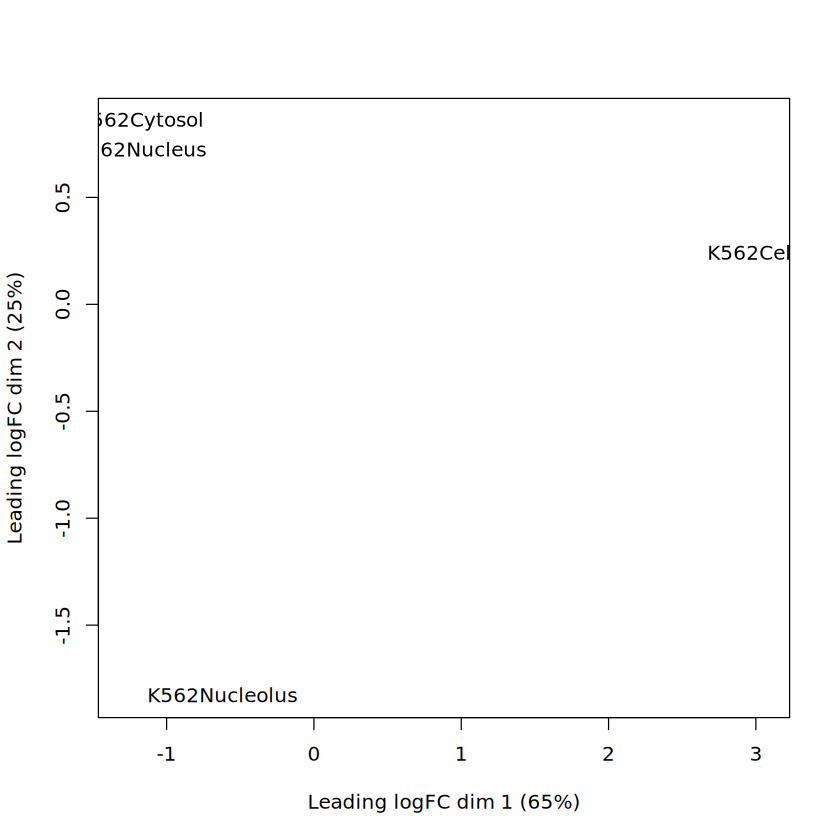

In [8]:
# Plot samples on a two-dimensional scatterplot so that distances
#   on the plot approximate the expression differences between the samples.

plotMDS(data_normalized, top = 700)


# Bibliography

[1] Y. Chen, L. Chen, A. T. L. Lun, P. L. Baldoni, and G. K. Smyth, “edgeR 4.0: powerful differential analysis of sequencing data with expanded functionality and improved support for small counts and larger datasets.” Jan. 24, 2024. doi: 10.1101/2024.01.21.576131.

[2] Y. Chen et al., “edgeR.” 2017. doi: 10.18129/B9.BIOC.EDGER.

[3] Y. Chen, D. McCarthy, P. Baldoni, M. Robinson, and G. Smyth, “edgeR: differential analysis of sequence read count data User’s Guide.” [Online]. Available: https://bioconductor.org/packages/release/bioc/html/edgeR.html
